In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar

# Data Cleaning

In [61]:
#import the file to be read
# whole data set
df_accid = pd.read_csv('NYPD_Motor_Vehicle_Collisions.csv')

/Users/amyrenae/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
#drop unnecessary columns
df_accid.drop(columns=['ZIP CODE', 'LOCATION', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
                       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
                       'CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2',
                       'CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4',
                       'CONTRIBUTING FACTOR VEHICLE 5'], inplace=True)

In [63]:
# set column data types
df_accid['DATETIME'] = pd.to_datetime(df_accid['DATE'] + " " + df_accid['TIME'], format="%m/%d/%Y %H:%M")
df_accid['NUMBER OF CYCLIST INJURED'] = df_accid['NUMBER OF CYCLIST INJURED'].astype('int64')
df_accid['NUMBER OF CYCLIST KILLED'] = df_accid['NUMBER OF CYCLIST KILLED'].astype('int64')
df_accid['UNIQUE KEY'] = df_accid['UNIQUE KEY'].astype('object')
df_accid['ON STREET NAME'] = df_accid['ON STREET NAME'].str.upper().str.strip()
df_accid['CROSS STREET NAME'] = df_accid['CROSS STREET NAME'].str.upper().str.strip()
df_accid['OFF STREET NAME'] = df_accid['OFF STREET NAME'].str.upper().str.strip()
df_accid['OFF STREET NAME'] = df_accid['OFF STREET NAME'].str.replace("        ", " ")
df_accid['OFF STREET NAME'] = df_accid['OFF STREET NAME'].str.replace("       ", " ")

# column.str.replace('\s*','')

In [64]:
df_accid = df_accid[['DATETIME', 'BOROUGH', 'LATITUDE', 'LONGITUDE', 'ON STREET NAME', 
                     'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF CYCLIST INJURED', 
                     'NUMBER OF CYCLIST KILLED', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
                     'VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']]

### Repairing inconsistent values for bicycle

In [6]:
# GROUPING COLUMNS
veh_col = ['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
cyc_col = ['NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED']

# CLEAN UP INCONSISTENT VALUES FOR BICYCLE
dif_names = ['BIKE', 'BICYC', 'Bike', 'bicyc', 'BK']
for col_name in veh_col:
    for w_name in dif_names:
        df_accid.loc[df_accid[col_name] == w_name, col_name] = 'BICYCLE'

In [7]:
#set the conditional statements 
BIKE_INJ = df_accid['NUMBER OF CYCLIST INJURED'] > 0
BIKE_INV = df_accid['NUMBER OF CYCLIST KILLED'] > 0
IS_BIKE = df_accid['VEHICLE TYPE CODE 1'] == 'BICYCLE'
IS_BIKE2 = df_accid['VEHICLE TYPE CODE 2'] == 'BICYCLE'
IS_BIKE3 = df_accid['VEHICLE TYPE CODE 3'] == 'BICYCLE'
IS_BIKE4 = df_accid['VEHICLE TYPE CODE 4'] == 'BICYCLE'
IS_BIKE5 = df_accid['VEHICLE TYPE CODE 5'] == 'BICYCLE'

# The dataframe only includes rows that meet one of the conditions listed (| means or)
df_accid = df_accid[BIKE_INJ | BIKE_INV | IS_BIKE | IS_BIKE2 | IS_BIKE3 | IS_BIKE4 | IS_BIKE5]

### Finding Closest Coordinate Match for Missing Borough Name 

In [8]:
#conditionals for borough null values
NO_borough = df_accid['BOROUGH'].isnull()
yes_borough = df_accid['BOROUGH'].notnull()

#rows that have both latitude and longitutde values
yes_lat_lon = df_accid['LATITUDE'].notnull() & df_accid['LONGITUDE'].notnull()

# separate dataframes for null and non-null borough values with filled lat/longitude 
df_noborough = df_accid[NO_borough & yes_lat_lon]
df_yesborough = df_accid[yes_borough & yes_lat_lon]

In [9]:
# fills empty borough values with closest lat/long match for borough
def return_borough(inda):
    df_yesborough['distance'] = (((df_yesborough['LATITUDE'] - df_accid.loc[inda, 'LATITUDE'])**2)+((df_yesborough['LONGITUDE'] - df_accid.loc[inda, 'LONGITUDE'])**2))
    df_sorted = df_yesborough.sort_values(by='distance')
    return df_sorted.iloc[0,1]

list_no_boroughs = list(df_noborough.index)
for ind in list_no_boroughs:
    new_borough = return_borough(ind)
    df_accid.loc[ind, 'BOROUGH'] = new_borough
    
# df_accid.loc[list_no_boroughs].head(1)

/Users/amyrenae/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Finding matching cross streets for missing borough names

In [10]:
# fills empty borough values with matching street intersections borough
NO_borough = df_accid['BOROUGH'].isnull()
yes_borough = df_accid['BOROUGH'].notnull()

yes_streets = df_accid['ON STREET NAME'].notnull() & df_accid['CROSS STREET NAME'].notnull()

df_xstreet = df_accid[NO_borough & yes_streets]
df_yxstreet = df_accid[yes_borough & yes_streets]

df_xstreet = df_xstreet[['BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME']]
df_yxstreet = df_yxstreet[['BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME']]

df_yxstreet = df_yxstreet.sort_values(by=['ON STREET NAME', 'CROSS STREET NAME'])
df_xstreet = df_xstreet.sort_values(by=['ON STREET NAME', 'CROSS STREET NAME'])

list_no_borough_xstreet = list(df_xstreet.index)

In [11]:
# a loop to find matching street pairs between those rows that don't have boroughs and those that do to fill in the missing boroughs
for ind in list_no_borough_xstreet:
    on_street_name = df_xstreet.loc[ind, 'ON STREET NAME']
    cr_street_name = df_xstreet.loc[ind, 'CROSS STREET NAME']
    df_street = df_yxstreet[(df_yxstreet['ON STREET NAME']==on_street_name)|(df_yxstreet['CROSS STREET NAME']==on_street_name)]
    list_yes_borough = list(df_street.index)
    for indy in list_yes_borough:
        y_on_street_name = df_street.loc[indy, 'ON STREET NAME']
        y_cr_street_name = df_street.loc[indy, 'CROSS STREET NAME']
        if ((on_street_name==y_on_street_name)&(cr_street_name==y_cr_street_name)) | ((on_street_name==y_cr_street_name)&(cr_street_name==y_on_street_name)):
            n_borough = df_street.loc[indy, 'BOROUGH']
            df_accid.loc[ind, 'BOROUGH'] = n_borough

In [12]:
# to fill the borough for specific streets
def fill_borough(street_name, borough_name):
    conditions = (df_accid['ON STREET NAME']==street_name)|(df_accid['CROSS STREET NAME']==street_name)
    df_accid.loc[conditions, 'BOROUGH'] = borough_name
    df_check = df_accid[(df_accid['ON STREET NAME']==street_name)|(df_accid['CROSS STREET NAME']==street_name)]
    
fill_borough('VAN WYCK EXPRESSWAY', 'QUEENS')
# df_check = df_accid[(df_accid['ON STREET NAME']=='VAN WYCK EXPRESSWAY')|(df_accid['CROSS STREET NAME']=='VAN WYCK EXPRESSWAY')]

In [13]:
# fill in manhattan for this address which is in Central Park
that_address = df_accid['OFF STREET NAME'] == "101 WEST DRIVE"
df_accid.loc[that_address, 'BOROUGH'] = 'MANHATTAN'
that_address = df_accid[that_address]

In [14]:
# save the updates to the file
df_accid.to_csv('NYC_Collisions.csv')

# Dataframe w/ Cleaned Data

In [3]:
# import written CSV into dataframe with column data types
df_accid = pd.read_csv('NYC_Collisions.csv', index_col=0)
df_accid['DATETIME'] = pd.to_datetime(df_accid['DATETIME'])

### Rounding to Half Hour

In [4]:
# rounding all times closer to midnight to the next day
late = df_accid['DATETIME'].dt.strftime('%H:%M').between('23:45', '23:59')
# DateOffset adds a day to the date since it will be the next day if you round up to the next hour
df_accid.loc[late, 'DATETIME'] = pd.to_datetime(df_accid['DATETIME'].apply(pd.DateOffset(1)).dt.strftime('%Y-%m-%d') + ' ' + '00:00')

# adding an hour to all the other times where it's closer to the next hour
df_accid['DATETIME'] = pd.to_datetime(df_accid['DATETIME'])
round_up = df_accid['DATETIME'].dt.strftime('%M').between('45', '59')
df_accid.loc[round_up, 'DATETIME'] = pd.to_datetime(df_accid['DATETIME'].apply(pd.DateOffset(hours=1)).dt.strftime('%Y-%m-%d %H:') + '00')

In [5]:
# rounding all the times to half hours. Any 
time_15 = df_accid['DATETIME'].dt.strftime('%M').between('01', '14')
df_accid.loc[time_15, 'DATETIME'] = pd.to_datetime(df_accid['DATETIME'].dt.strftime('%Y-%m-%d %H:') + '00')

time_30 = df_accid['DATETIME'].dt.strftime('%M').between('15', '44')
df_accid.loc[time_30, 'DATETIME'] = pd.to_datetime(df_accid['DATETIME'].dt.strftime('%Y-%m-%d %H:') + '30')

In [6]:
df_accid['DATETIME'] = pd.to_datetime(df_accid['DATETIME'])
df_accid['BOROUGH'] = df_accid['BOROUGH'].fillna('UNSPEC')

In [7]:
# limiting the date range of the dataframe since both 2012 are incomplete
df_accid = df_accid[df_accid.DATETIME.between('2013-01-01', '2019-01-01')]

### Graph Reference Lists

In [8]:
leg_labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Unspecified', 'Total for All Boroughs']
hours = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']
colors_a = ['#4ca6ff', '#ffff48', '#73ec5c', '#ff6d6d', '#8a3ea4', '#ababab', '#db71db']

## Number of Accidents by Month

In [9]:
# number of accidents involving bicycles by month
piv_month = df_accid.pivot_table(index=df_accid['DATETIME'].dt.strftime('%m'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_month['All Boroughs'] = piv_month.sum(axis=1)

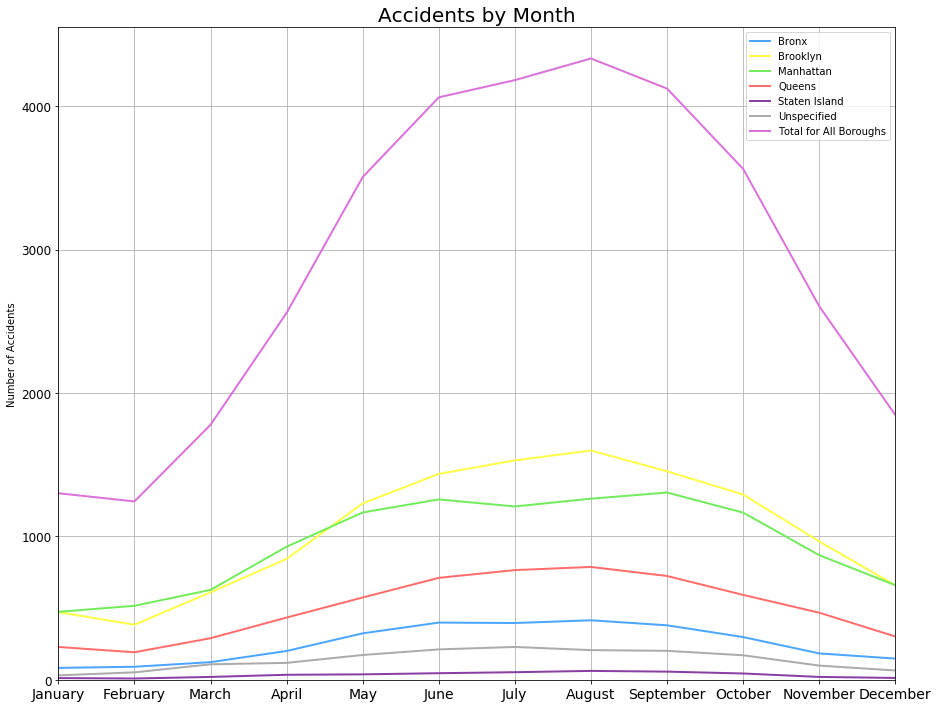

In [10]:
# make the graph of accidents per borough
piv_month.plot.line(linewidth=2, figsize=(15,12), color=colors_a)

plt.title('Accidents by Month', fontsize=20)
plt.xlabel('')
plt.ylabel('Number of Accidents')

plt.xticks(np.arange(12), calendar.month_name[1:13], fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(bottom=0)

plt.legend(labels=leg_labels)

plt.grid()
plt.show()

## Number of Accidents by Hour 

In [11]:
hours = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']

In [12]:
# pivot table that counts the number of accidents that occur in each hour by borough. 
piv_hour = df_accid.pivot_table(index=df_accid['DATETIME'].dt.strftime('%H'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count') 
piv_hour['All Boroughs'] = piv_hour.sum(axis=1)

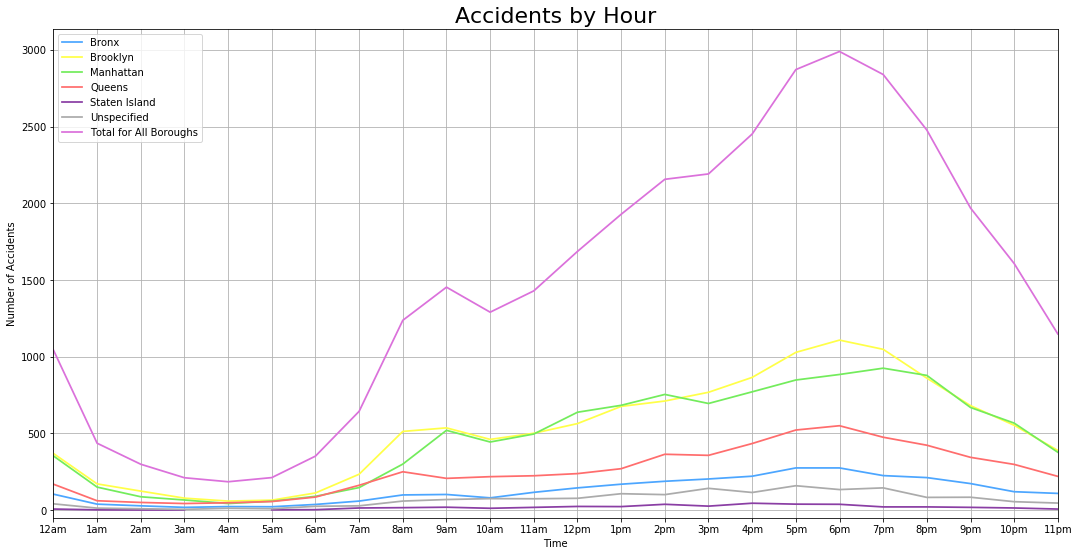

In [13]:
# all boroughs/times by hour
piv_hour.plot.line(figsize=(18,9), linewidth=1.75, color=colors_a)

plt.title('Accidents by Hour', fontsize=22)
plt.xlabel('Time')
plt.ylabel('Number of Accidents')
plt.xticks(np.arange(0,24,1), hours)
plt.ylim(bottom=-50)

plt.legend(labels=leg_labels)

plt.grid()
plt.show()

## Number of Accidents by Half Hour

In [14]:
# a pivot table to count the number of accidents that occur at different times of day by borough
piv_half_hour = df_accid.pivot_table(index=df_accid['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_half_hour['All Boroughs'] = piv_half_hour.sum(axis=1)

/Users/amyrenae/Library/Python/3.7/lib/python/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


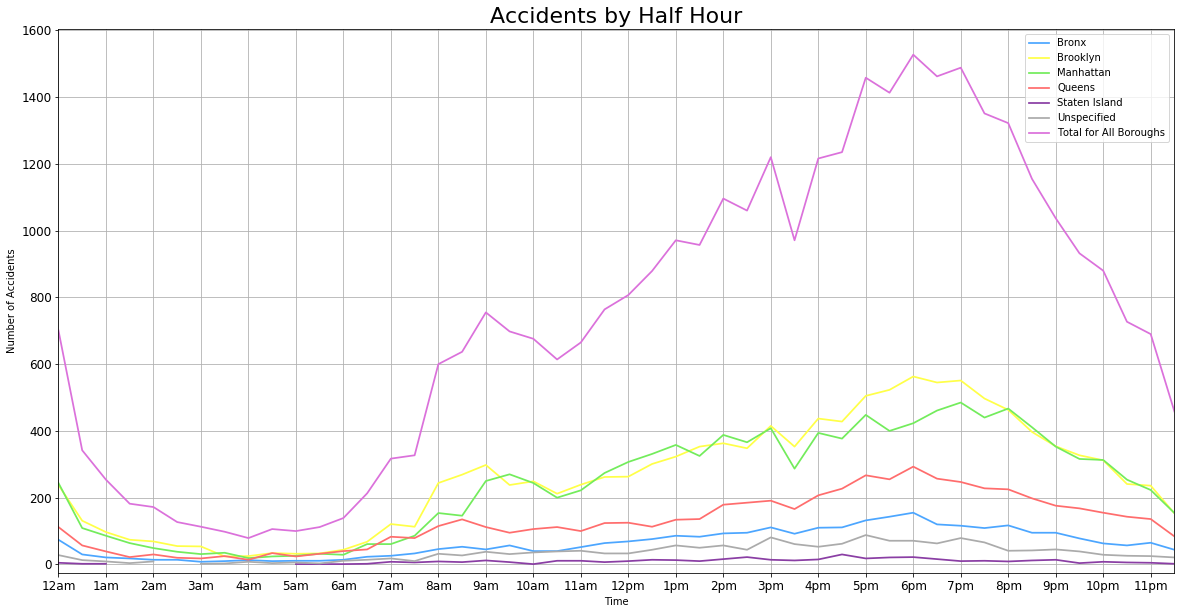

In [15]:
piv_half_hour.plot.line(linewidth=1.75, colors=colors_a, figsize=(20,10))
plt.title('Accidents by Half Hour', fontsize=22)
plt.xlabel('Time')
plt.ylabel('Number of Accidents')

plt.xticks(np.arange(0,48,2), hours, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(bottom=-25)

plt.legend(labels=leg_labels)

plt.grid()
plt.show()

## Weekday

In [16]:
# SETTING data frames that are either just week days or weekends
wkday = df_accid[df_accid['DATETIME'].dt.weekday.between(0,4)]
piv_hour_wkday = wkday.pivot_table(index=wkday['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_wkday['All Boroughs'] = piv_hour_wkday.sum(axis=1)

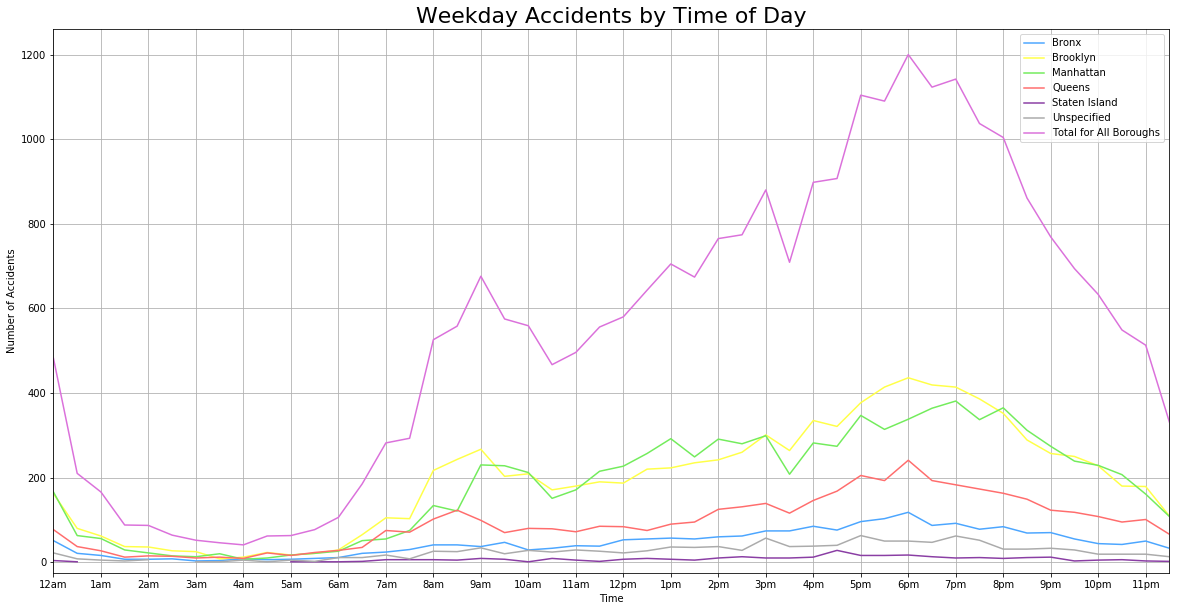

In [17]:
# WEEKDAYS days by half hour
piv_hour_wkday.plot.line(colors=colors_a, figsize=(20,10))
plt.title('Weekday Accidents by Time of Day', fontsize=22)
plt.xlabel('Time')
plt.ylabel('Number of Accidents')

plt.xticks(np.arange(0,48,2), hours)
plt.ylim(bottom=-25)

plt.legend(labels=leg_labels)

plt.grid()
plt.show()

## Weekend

In [18]:
# Slice and pivot table and sum column
wkend = df_accid[df_accid['DATETIME'].dt.weekday.between(5,6)]
piv_hour_wkend = wkend.pivot_table(index=wkend['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_wkend['All boroughs'] = piv_hour_wkend.sum(axis=1)

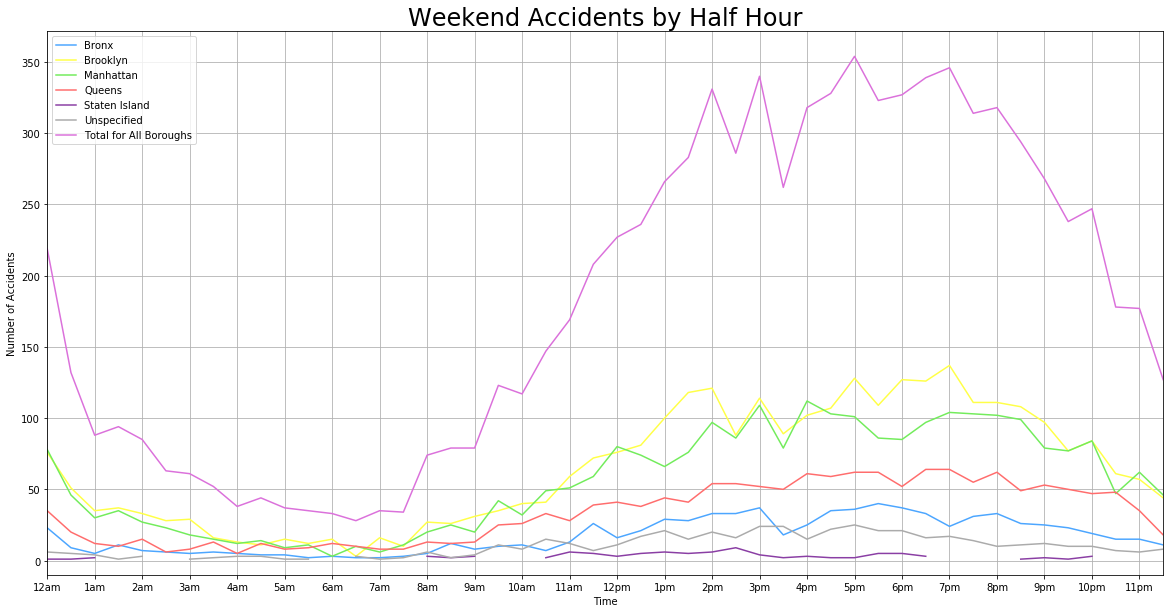

In [19]:
# WEEKEND graph (time of day by borough)
piv_hour_wkend.plot.line(colors=colors_a, figsize=(20,10))

plt.title("Weekend Accidents by Half Hour", fontsize=24)
plt.xlabel('Time')
plt.ylabel('Number of Accidents')

plt.xticks(np.arange(0,48,2), hours)
plt.ylim(bottom=-10)

plt.legend(labels=leg_labels)

plt.grid()
plt.show()

## Dataframes & Pivot Tables for Each Year

In [20]:
#separating out the years
df_accid_13 = df_accid[df_accid.DATETIME.between('2013-01-01', '2014-01-01')]
df_accid_14 = df_accid[df_accid.DATETIME.between('2014-01-01', '2015-01-01')]
df_accid_15 = df_accid[df_accid.DATETIME.between('2015-01-01', '2016-01-01')]
df_accid_16 = df_accid[df_accid.DATETIME.between('2016-01-01', '2017-01-01')]
df_accid_17 = df_accid[df_accid.DATETIME.between('2017-01-01', '2018-01-01')]
df_accid_18 = df_accid[df_accid.DATETIME.between('2018-01-01', '2019-01-01')]

piv_hour_13 = df_accid_13.pivot_table(index=df_accid['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_13['total'] = piv_hour_13.sum(axis=1)
piv_hour_14 = df_accid_14.pivot_table(index=df_accid['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_14['total'] = piv_hour_14.sum(axis=1)
piv_hour_15 = df_accid_15.pivot_table(index=df_accid['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_15['total'] = piv_hour_15.sum(axis=1)
piv_hour_16 = df_accid_16.pivot_table(index=df_accid['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_16['total'] = piv_hour_16.sum(axis=1)
piv_hour_17 = df_accid_17.pivot_table(index=df_accid['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_17['total'] = piv_hour_17.sum(axis=1)
piv_hour_18 = df_accid_18.pivot_table(index=df_accid['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_18['total'] = piv_hour_18.sum(axis=1)

## Graphs for Each Year

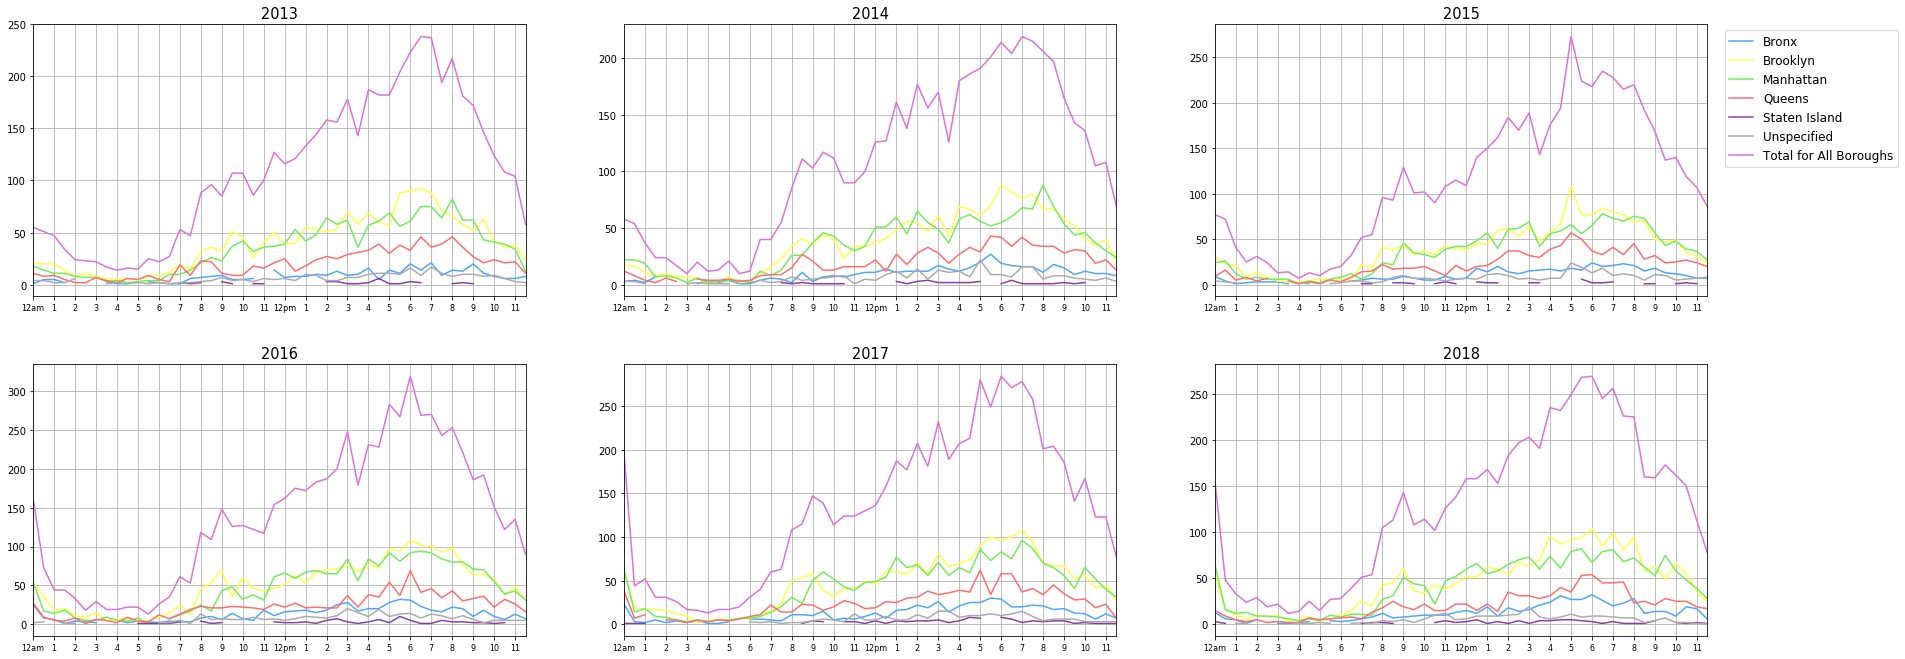

In [44]:
alt_hours = ['12am', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12pm', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
sm_ln = {'tfnt': 14.5, 'xtik': 8, 'xlbl': 8, 'lfnt': 12}

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3, figsize=(30,11.25))

all_ax = [ax0, ax1, ax2, ax3, ax4, ax5]
df_list = [piv_hour_13, piv_hour_14, piv_hour_15, piv_hour_16, piv_hour_17, piv_hour_18]
years = ["2013", "2014", "2015", "2016", "2017", "2018"]

for counter, df in enumerate(df_list):
	df.plot.line(colors=colors_a, legend=False, ax=all_ax[counter])
	all_ax[counter].set_title(years[counter], fontsize=sm_ln['tfnt'])
	all_ax[counter].set_xticks(np.arange(0,48,2))
	all_ax[counter].set_xticklabels(alt_hours, fontsize=sm_ln['xtik'])
	all_ax[counter].set_xlabel('', fontsize=sm_ln['xlbl'])
	all_ax[counter].xaxis.grid()
	all_ax[counter].yaxis.grid()

ax2.legend(fontsize=sm_ln['lfnt'], labels=leg_labels, bbox_to_anchor=(1.4, 1))
    
fig.subplots_adjust(hspace=0.25)

plt.show()

In [22]:
yr_fm = {'sz': (10,5), 'tfont': 22, 'xlbl': 'Time', 'xfont': 9, 'ylbl': 'Number of Accidents', 'yfont': 10, 'xtik': 8.5, 'lfont': 8}

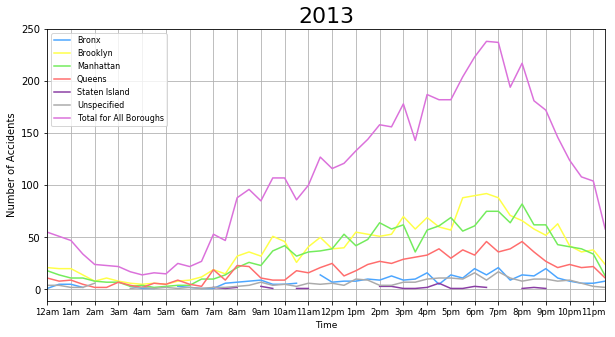

In [23]:
piv_hour_13.plot.line(figsize=yr_fm['sz'], color=colors_a)
plt.title("2013", fontsize=yr_fm['tfont'])
plt.xlabel(yr_fm['xlbl'], fontsize=yr_fm['xfont'])
plt.ylabel(yr_fm['ylbl'], fontsize=yr_fm['yfont'])
plt.xticks(np.arange(0,48,2), hours, fontsize=yr_fm['xtik'])
plt.legend(fontsize=yr_fm['lfont'], labels=leg_labels)
plt.grid()
plt.show()

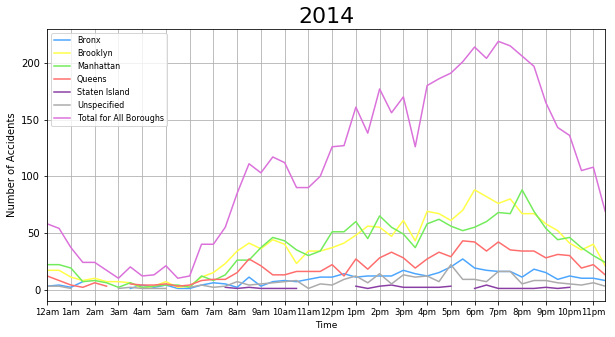

In [24]:
piv_hour_14.plot.line(figsize=yr_fm['sz'], color=colors_a)
plt.title("2014", fontsize=yr_fm['tfont'])
plt.xlabel(yr_fm['xlbl'], fontsize=yr_fm['xfont'])
plt.ylabel(yr_fm['ylbl'], fontsize=yr_fm['yfont'])
plt.xticks(np.arange(0,48,2), hours, fontsize=yr_fm['xtik'])
plt.legend(fontsize=yr_fm['lfont'], labels=leg_labels)
plt.grid()
plt.show()

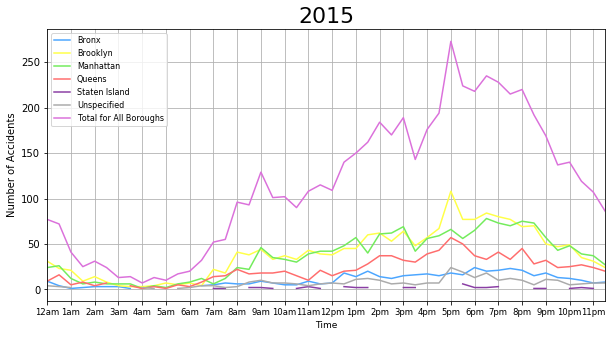

In [25]:
piv_hour_15.plot.line(figsize=yr_fm['sz'], color=colors_a)
plt.title("2015", fontsize=yr_fm['tfont'])
plt.xlabel(yr_fm['xlbl'], fontsize=yr_fm['xfont'])
plt.ylabel(yr_fm['ylbl'], fontsize=yr_fm['yfont'])
plt.xticks(np.arange(0,48,2), hours, fontsize=yr_fm['xtik'])
plt.legend(fontsize=yr_fm['lfont'], labels=leg_labels)
plt.grid()
plt.show()

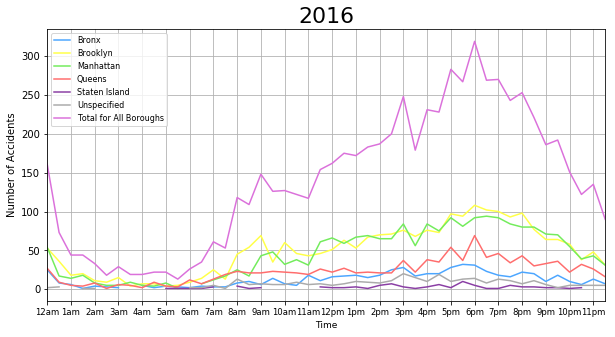

In [26]:
piv_hour_16.plot.line(figsize=yr_fm['sz'], color=colors_a)
plt.title("2016", fontsize=yr_fm['tfont'])
plt.xlabel(yr_fm['xlbl'], fontsize=yr_fm['xfont'])
plt.ylabel(yr_fm['ylbl'], fontsize=yr_fm['yfont'])
plt.xticks(np.arange(0,48,2), hours, fontsize=yr_fm['xtik'])
plt.legend(fontsize=yr_fm['lfont'], labels=leg_labels)
plt.grid()
plt.show()

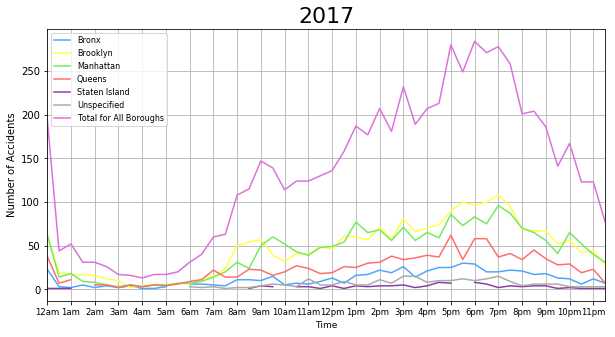

In [27]:
piv_hour_17.plot.line(figsize=yr_fm['sz'], color=colors_a)
plt.title("2017", fontsize=yr_fm['tfont'])
plt.xlabel(yr_fm['xlbl'], fontsize=yr_fm['xfont'])
plt.ylabel(yr_fm['ylbl'], fontsize=yr_fm['yfont'])
plt.xticks(np.arange(0,48,2), hours, fontsize=yr_fm['xtik'])
plt.legend(fontsize=yr_fm['lfont'], labels=leg_labels)
plt.grid()
plt.show()

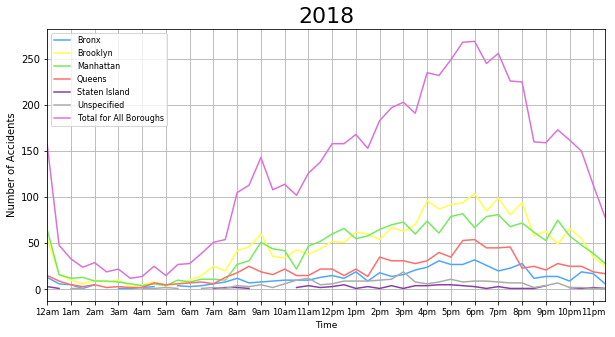

In [28]:
piv_hour_18.plot.line(figsize=yr_fm['sz'], color=colors_a)
plt.title("2018", fontsize=yr_fm['tfont'])
plt.xlabel(yr_fm['xlbl'], fontsize=yr_fm['xfont'])
plt.ylabel(yr_fm['ylbl'], fontsize=yr_fm['yfont'])
plt.xticks(np.arange(0,48,2), hours, fontsize=yr_fm['xtik'])
plt.legend(fontsize=yr_fm['lfont'], labels=leg_labels)
plt.grid()
plt.show()

## Total Number of Accidents by Time of Day by Year

In [29]:
df_yrs = df_accid
df_yrs['yr'] = df_yrs.DATETIME.dt.strftime('%Y')
piv_yrs = df_yrs.pivot_table(index=df_yrs['DATETIME'].dt.strftime('%H:%M'), columns='yr', values='UNIQUE KEY', aggfunc='count')

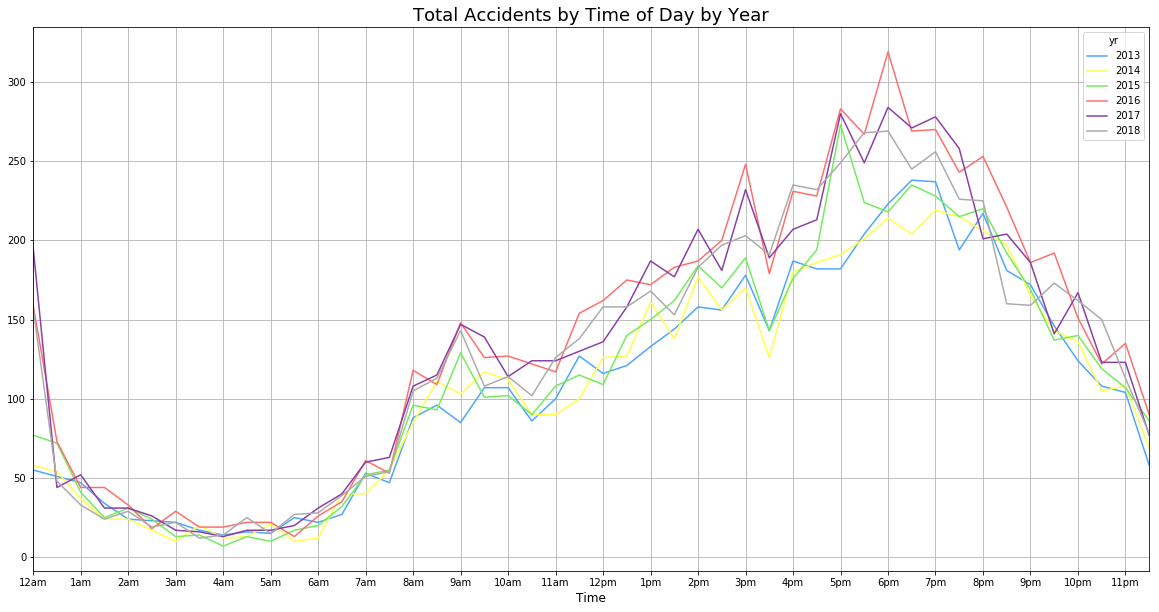

In [30]:
piv_yrs.plot.line(colors=colors_a, figsize=(20,10))
plt.title('Total Accidents by Time of Day by Year', fontsize=18)
plt.xlabel('Time', fontsize=12)
plt.xticks(np.arange(0,48,2), hours)
plt.grid()
plt.show()

## Dataframes for Daylight Savings and Not Daylight Savings

In [31]:
#DAYLIGHT SAVINGS TIME CONDITIONALS
#not Daylight Savings
nd1 = (df_accid.DATETIME.between('2013-01-01','2013-03-10'))|(df_accid.DATETIME.between('2013-11-03','2014-03-09'))
nd2 = (df_accid.DATETIME.between('2014-11-02','2015-03-08'))|(df_accid.DATETIME.between('2015-11-01','2016-03-13'))
nd3 = (df_accid.DATETIME.between('2016-11-06','2017-03-12'))|(df_accid.DATETIME.between('2017-11-05','2018-03-11'))

#Daylight Savings
d1 = (df_accid.DATETIME.between('2013-03-10','2013-11-03'))|(df_accid.DATETIME.between('2014-03-09','2014-11-03'))
d2 = (df_accid.DATETIME.between('2015-03-08','2015-11-01'))|(df_accid.DATETIME.between('2016-03-13','2016-11-06'))
d3 = (df_accid.DATETIME.between('2017-03-12','2017-11-05'))|(df_accid.DATETIME.between('2018-03-11','2019-01-01'))

NO_DAYLIGHT = df_accid[nd1|nd2|nd3]
YS_DAYLIGHT = df_accid[d1|d2|d3]

piv_hour_nodaylight = NO_DAYLIGHT.pivot_table(index=NO_DAYLIGHT['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_nodaylight['TOTAL'] = piv_hour_nodaylight.sum(axis=1)
piv_hour_daylight = YS_DAYLIGHT.pivot_table(index=YS_DAYLIGHT['DATETIME'].dt.strftime('%H:%M'), columns='BOROUGH', values='UNIQUE KEY', aggfunc='count')
piv_hour_daylight['TOTAL'] = piv_hour_daylight.sum(axis=1)
# piv_hour_nodaylight

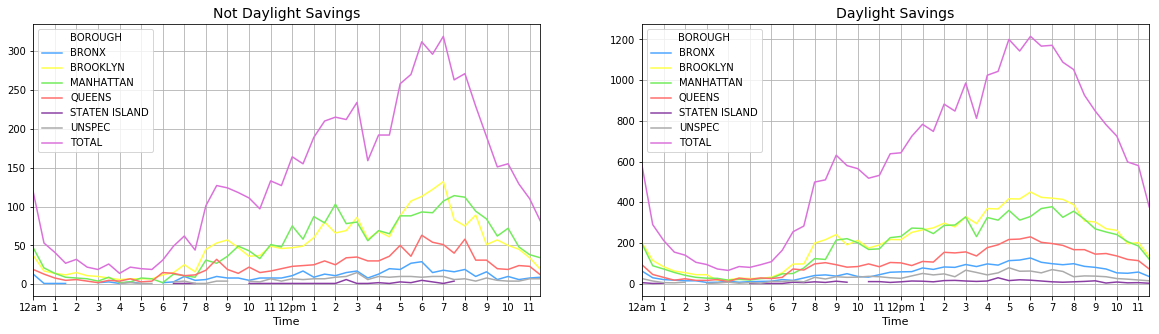

In [32]:
alt_hours = ['12am', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12pm', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
fig = plt.figure(figsize=(20,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

piv_hour_nodaylight.plot.line(ax=ax0, color=colors_a)
ax0.set_title("Not Daylight Savings", fontsize=14)
ax0.set_xticks(np.arange(0,48,2))
ax0.set_xticklabels(alt_hours, fontsize=10)
ax0.set_xlabel('Time', fontsize=11)
ax0.xaxis.grid()
ax0.yaxis.grid()

piv_hour_daylight.plot.line(ax=ax1, color=colors_a)
ax1.set_title("Daylight Savings", fontsize=14)
ax1.set_xticks(np.arange(0,48,2))
ax1.set_xticklabels(alt_hours, fontsize=10)
ax1.set_xlabel('Time', fontsize=11)

plt.grid()
plt.show()

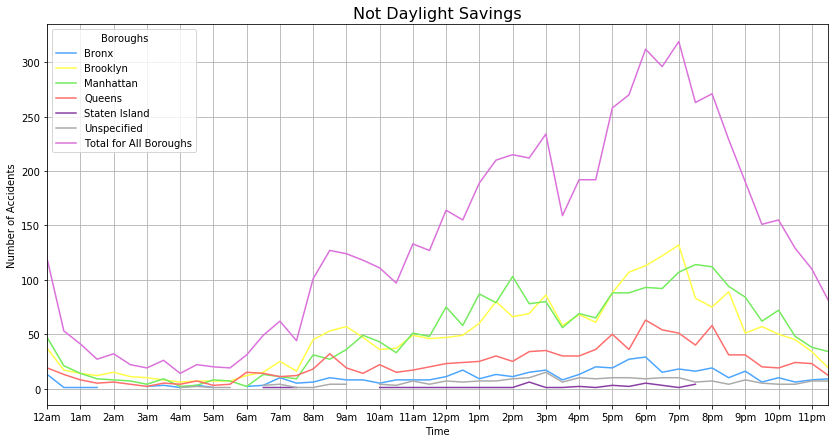

In [33]:
piv_hour_nodaylight.plot.line(colors=colors_a, figsize=(14,7))
plt.xticks(np.arange(0,48,2), hours)
plt.title('Not Daylight Savings', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Number of Accidents')

plt.legend(title='Boroughs', labels=leg_labels)
plt.grid()
plt.show()

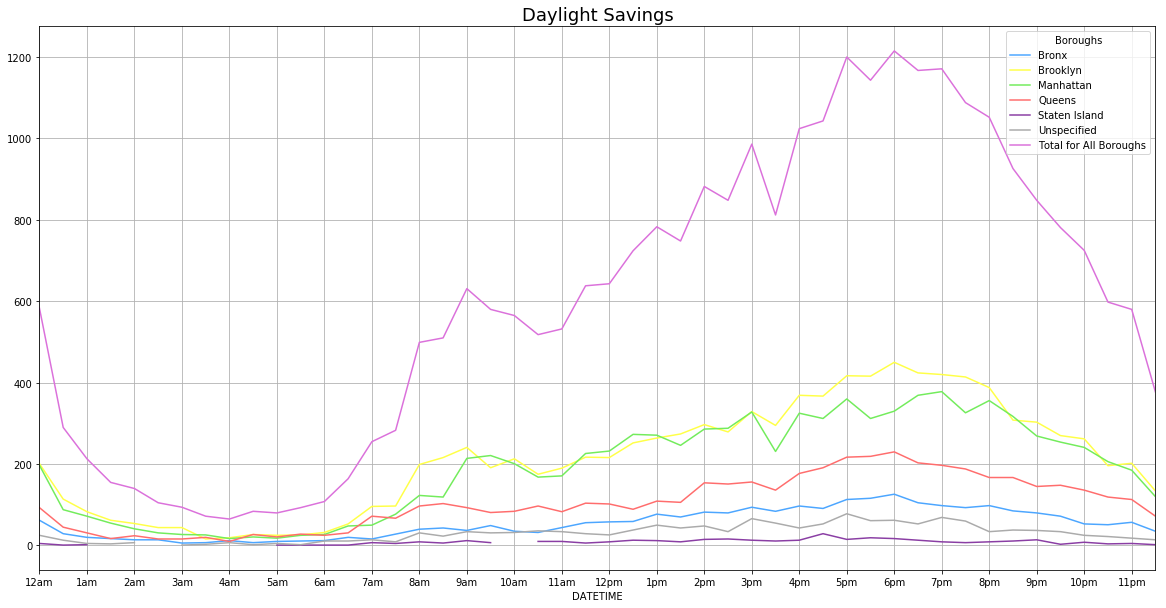

In [34]:
piv_hour_daylight.plot(colors=colors_a, figsize=(20,10))

plt.title('Daylight Savings', fontsize=18)
plt.xticks(np.arange(0,48,2), hours)
plt.legend(title='Boroughs', labels=leg_labels)

plt.grid()
plt.show()

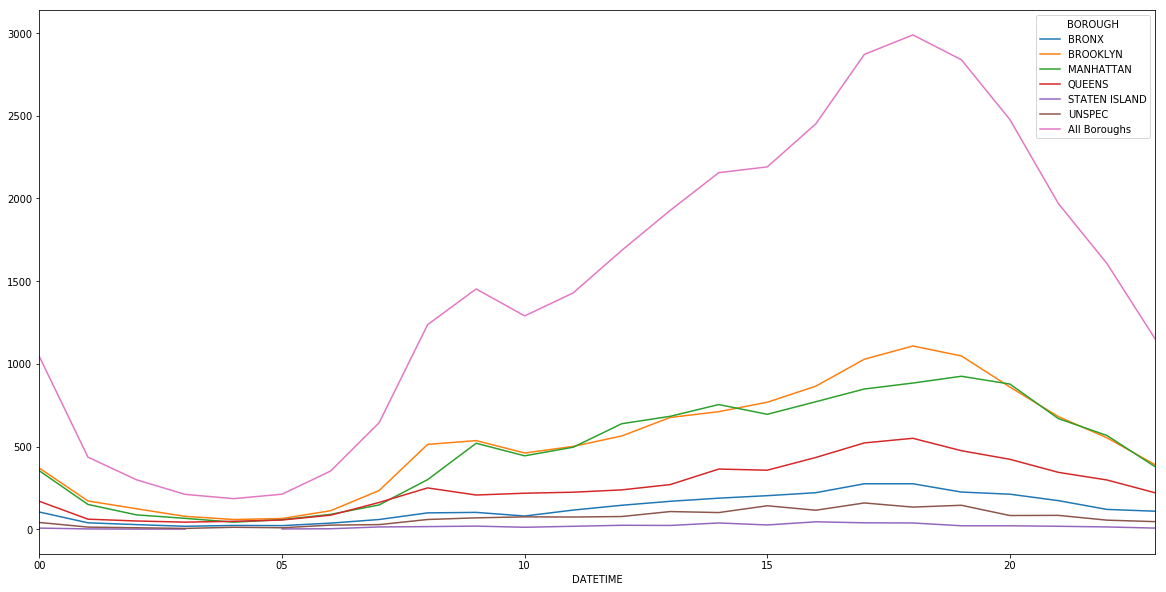

In [35]:
piv_hour.plot.line(figsize=(20,10))
# plt.xticks(np.arange(0,24,1), hours)
plt.show()

In [36]:
# group by borough
df_brooklyn = df_accid['BOROUGH'] == 'BROOKLYN'
df_bronx = df_accid['BOROUGH'] == 'BRONX'
df_manhattan = df_accid['BOROUGH'] == 'MANHATTAN'
df_staten = df_accid['BOROUGH'] == 'STATEN ISLAND'
df_queens = df_accid['BOROUGH'] == 'QUEENS'

In [37]:
df_borough = df_accid.groupby('BOROUGH').agg({'UNIQUE KEY': ['count'], 'NUMBER OF CYCLIST INJURED': ['sum'], 'NUMBER OF CYCLIST KILLED': ['sum']})
df_borough

,UNIQUE KEY,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
,count,sum,sum
BOROUGH,,,
BRONX,3042,2469,10
BROOKLYN,12474,10109,34
MANHATTAN,11443,7713,26
QUEENS,6068,5007,24
STATEN ISLAND,409,332,2
UNSPEC,1667,1344,7


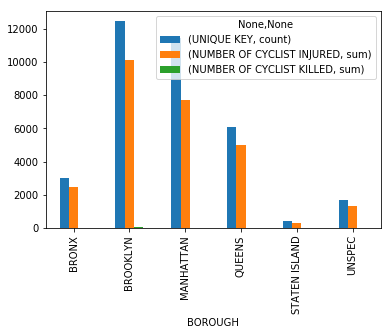

In [38]:
df_borough.plot.bar()
plt.show()

In [39]:
# group by year
by_year = df_accid.groupby(df_accid.DATETIME.dt.year).agg({'NUMBER OF CYCLIST INJURED': ['sum'], 'NUMBER OF CYCLIST KILLED': ['sum'], 'UNIQUE KEY': ['count']})
by_year = by_year['NUMBER OF CYCLIST KILLED']

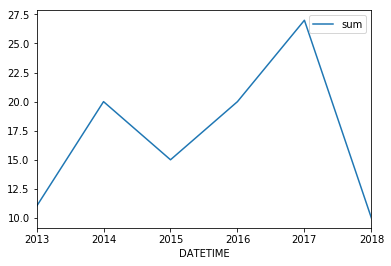

In [40]:
by_year.plot.line()
plt.show()

In [41]:
# add a total row
df_accid.loc['t_row'] = df_accid.sum(numeric_only=True)
df_accid.loc['t_row', cyc_col]

NameError: name 'cyc_col' is not defined

In [ ]:
#drop the total row so that we don't accidentally count stuff 2x
df_accid = df_accid.drop('t_row')
df_accid.tail(1)